In [2]:
import pandas as pd
import h5py as h5
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM ,Dropout , Dense, Bidirectional , convolutional
from keras.optimizers import Adam
from keras.layers.core import Reshape
import tensorflow
# from tensorflow.python.keras.layers import Dense , LSTM ,Dropout
# from tensorflow.python.keras import Sequential
from sklearn.model_selection import train_test_split
import keras
from keras.utils import Sequence

In [2]:
all_x = np.load('./all_x_60_to_700.npy', allow_pickle=True)
all_y = np.load('./all_y_60_to_700.npy', allow_pickle=True)

In [3]:
np.sum((all_y+1)/2, axis=0)

array([32805., 27305., 34670., 28325.])

In [4]:
C_all_x = all_x[all_y[:,0]>0, :,:,:]
A_all_x = all_x[all_y[:,1]>0, :,:,:]
G_all_x = all_x[all_y[:,2]>0, :,:,:]
U_all_x = all_x[all_y[:,3]>0, :,:,:]

C_all_y = all_y[all_y[:,0]>0, :]
A_all_y = all_y[all_y[:,1]>0, :]
G_all_y = all_y[all_y[:,2]>0, :]
U_all_y = all_y[all_y[:,3]>0, :]



In [5]:
print(C_all_x.shape, A_all_x.shape, G_all_x.shape, U_all_x.shape)
print(C_all_y.shape, A_all_y.shape, G_all_y.shape, U_all_y.shape) 

(32805, 15, 6, 3) (27305, 15, 6, 3) (34670, 15, 6, 3) (28325, 15, 6, 3)
(32805, 4) (27305, 4) (34670, 4) (28325, 4)


In [6]:
training_class_size = 27300
all_unbiased_x = C_all_x[:training_class_size,:,:,:]
all_unbiased_x = np.append(all_unbiased_x, A_all_x[:training_class_size,:,:,:], axis=0)
all_unbiased_x = np.append(all_unbiased_x, G_all_x[:training_class_size,:,:,:], axis=0)
all_unbiased_x = np.append(all_unbiased_x, U_all_x[:training_class_size,:,:,:], axis=0)

print(all_unbiased_x.shape)

(109200, 15, 6, 3)


In [7]:
all_unbiased_y = C_all_y[:training_class_size,:]
all_unbiased_y = np.append(all_unbiased_y, A_all_y[:training_class_size,:], axis=0)
all_unbiased_y = np.append(all_unbiased_y, G_all_y[:training_class_size,:], axis=0)
all_unbiased_y = np.append(all_unbiased_y, U_all_y[:training_class_size,:], axis=0)

print(all_unbiased_y.shape)

(109200, 4)


In [8]:
all_x = all_unbiased_x
all_y = all_unbiased_y

In [9]:
new_validation_all_x = np.load('./new_0to50_all_x.npy', allow_pickle=True)
new_validation_all_y = np.load('./new_0to50_all_y.npy', allow_pickle=True)

In [10]:
np.sum((new_validation_all_y+1)/2, axis=0)

array([3632., 3118., 3802., 2864.])

In [11]:
all_x.shape, all_y.shape

((109200, 15, 6, 3), (109200, 4))

In [12]:
new_validation_all_x.shape, new_validation_all_y.shape

((13416, 15, 6, 3), (13416, 4))

In [13]:
(all_y[:3,:]+1)/2

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]])

In [14]:
np.sum((all_y+1)/2, axis=0)

array([27300., 27300., 27300., 27300.])

In [15]:
a = all_x[0]

In [16]:
a

array([[[-0.19737859681618652, 0.6391925333875103, -1.4440905770693875],
        [-0.23880048823341005, 0.7741651270470442, 1.1653255694799183],
        [0.0, 0.0, 0.0],
        [7.703973557864683e-16, 7.372631506887088e-16,
         2.4401807310115298],
        [1.4366594931531316, 4.440892098500626e-16, 2.959428745675932],
        [1.4374211622735515, 0.17539349071359567, 4.371953628032148]],

       [[1.5616975498849344, 1.654733646669109, 4.97627976718197],
        [0.5289081970772602, 0.6855864082676086, 7.179750162496127],
        [0.515814975807977, 1.6856542737965354, 6.172348141506886],
        [-0.6443361012163943, -0.24931978404878113, 7.05034294442129],
        [-1.804787428182497, 0.02772632046943324, 7.996694979191573],
        [-3.038599801105455, -0.21872047995765803, 7.334846051579328]],

       [[-4.334733709846882, 0.6665679051427407, 7.661923054465539],
        [-5.535506396136872, 0.4992789001471394, 5.3672151548261615],
        [-4.753252736707329, 1.2702014350084

In [17]:
all_x.shape

(109200, 15, 6, 3)

In [18]:
def convert_data_representation_to_point_cloud(x_batch):
    x_shifted_train = x_batch + 16.0
    x_cloud_point = np.zeros([x_shifted_train.shape[0], 32,32,32])
    for i in range(x_shifted_train.shape[0]):
      for j in range(x_shifted_train.shape[1]):
        for k in range(x_shifted_train.shape[2]):
          if np.any(x_shifted_train[i,j,k,:]>32) or np.any(x_shifted_train[i,j,k,:]<0):
            # no need to consider this data point
            pass
          else:
            dx = int(x_shifted_train[i,j,k,0])
            dy = int(x_shifted_train[i,j,k,1])
            dz = int(x_shifted_train[i,j,k,2])
            ##i inja chie? hamun 90? chera?
            x_cloud_point[i, dx, dy, dz] = 1.0 
    return x_cloud_point

class RNADataGenerator(Sequence):
    """Generates data for Keras
    Sequence based data generator.
    Suitable for building data generator for training and prediction.
    """
    def __init__(self, index_of_samples,
                 to_fit=True, batch_size=32,
                shuffle=True):
        """Initialization
        :param list_IDs: list of all 'label' ids to use in the generator
        :param labels: list of image labels (file names)
        :param to_fit: True to return X and y, False to return X only
        :param batch_size: batch size at each iteration
        :param shuffle: True to shuffle label indexes after every epoch
        """
        self.index_of_samples = index_of_samples
        self.to_fit = to_fit
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        """Denotes the number of batches per epoch
        :return: number of batches per epoch
        """
        return int(np.floor(self.index_of_samples.shape[0]/self.batch_size))

    def __getitem__(self, index):
        """Generate one batch of data
        :param index: index of the batch
        :return: X and y when fitting. X only when predicting
        """
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        # Find list of IDs
#         list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X = self._generate_X(indexes)

        if self.to_fit:
            y = self._generate_y(indexes)
            return X, y
        else:
            return X

    def on_epoch_end(self):
        """Updates indexes after each epoch
        """
        self.indexes = np.arange(self.index_of_samples.shape[0])
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def _generate_X(self, indexes):
        """Generates data containing batch_size images
        :param list_IDs_temp: list of label ids to load
        :return: batch of images
        """
        # Initialization
        # Generate data
        X = convert_data_representation_to_point_cloud(all_x[indexes, :, :, :])
        return X

    def _generate_y(self, indexes):
        """Generates data containing batch_size masks
        :param list_IDs_temp: list of label ids to load
        :return: batch if masks
        """
        y = (all_y[indexes,:]+1)/2

        return y

In [19]:
class RNADataGeneratorValidation(Sequence):
    """Generates data for Keras
    Sequence based data generator.
    Suitable for building data generator for training and prediction.
    """
    def __init__(self, index_of_samples,
                 to_fit=True, batch_size=32,
                shuffle=True):
        """Initialization
        :param list_IDs: list of all 'label' ids to use in the generator
        :param labels: list of image labels (file names)
        :param to_fit: True to return X and y, False to return X only
        :param batch_size: batch size at each iteration
        :param shuffle: True to shuffle label indexes after every epoch
        """
        self.index_of_samples = index_of_samples
        self.to_fit = to_fit
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        """Denotes the number of batches per epoch
        :return: number of batches per epoch
        """
        return int(np.floor(self.index_of_samples.shape[0]/self.batch_size))

    def __getitem__(self, index):
        """Generate one batch of data
        :param index: index of the batch
        :return: X and y when fitting. X only when predicting
        """
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        # Find list of IDs
#         list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X = self._generate_X(indexes)

        if self.to_fit:
            y = self._generate_y(indexes)
            return X, y
        else:
            return X

    def on_epoch_end(self):
        """Updates indexes after each epoch
        """
        self.indexes = np.arange(self.index_of_samples.shape[0])
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def _generate_X(self, indexes):
        """Generates data containing batch_size images
        :param list_IDs_temp: list of label ids to load
        :return: batch of images
        """
        # Initialization
        # Generate data
        X = convert_data_representation_to_point_cloud(new_validation_all_x[indexes, :, :, :])
        return X

    def _generate_y(self, indexes):
        """Generates data containing batch_size masks
        :param list_IDs_temp: list of label ids to load
        :return: batch if masks
        """
        y = (new_validation_all_y[indexes,:]+1)/2

        return y

In [20]:
all_x.shape

(109200, 15, 6, 3)

In [21]:

training_generator = RNADataGenerator(index_of_samples=np.array([i for i in range(int(all_y.shape[0]))]),
                                     to_fit=True, batch_size=32,shuffle=True)
validation_generator = RNADataGeneratorValidation(index_of_samples=np.array([i for i in range(int(new_validation_all_y.shape[0]))]),
                                       to_fit=True, batch_size=32)


# model

In [1]:
import numpy as np
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv3D, Dense, Softmax, Dropout, Input, Lambda, MaxPool3D
from tensorflow.keras.layers import Multiply, Concatenate, Reshape, LSTM, Flatten
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as tf
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
# from keras.utils.io_utils import HDF5Matrix
from sklearn.preprocessing import OneHotEncoder
# from Bio.PDB.Polypeptide import aa3, aa1
import h5py
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

In [2]:
from tensorflow.keras.layers import Conv1D, Input, Reshape
from tensorflow.keras.layers import concatenate, Concatenate, Multiply

In [3]:
x_cloud_inp = Input(shape=(32, 32, 32,1))

# x_reshaped_inp = Reshape((32*32*32,))(x_cloud_inp)

conv_layer_1 = Conv3D(32, (2,2,2))(x_cloud_inp)
conv_layer_2 = Conv3D(32, (2,2,2))(conv_layer_1)
maxpool_1 = MaxPool3D((2,2,2))(conv_layer_2)

conv_layer_3 = Conv3D(32, (3,3,3))(conv_layer_2)
conv_layer_4 = Conv3D(16, (3,3,3))(conv_layer_3)
maxpool_4 = MaxPool3D((2,2,2))(conv_layer_4)

# max_pool_1 = MaxPool3D((2,2,2))(conv_layer_4)

print(maxpool_4.shape)

reshaped_conv_1 = Reshape((13*13*13*16,))(maxpool_4)

layer_1 = Dense(256, activation='relu')(reshaped_conv_1)
layer_1_drop = Dropout(0.3)(layer_1)

layer_2 = Dense(256, activation='relu')(layer_1_drop)
layer_2_drop = Dropout(0.3)(layer_2)

layer_last = Dense(4, activation='softmax')(layer_2_drop)

output_layer = layer_last


(None, 13, 13, 13, 16)


In [4]:
epoch = 100
batch_size = 64
lr = 1.2e-6

In [5]:
model = Model([x_cloud_inp],output_layer)

In [51]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=1000,
    decay_rate=0.00001)

In [31]:
# model.compile(loss='categorical_crossentropy', optimizer=Adam(lr_schedule), metrics=['accuracy'])

In [52]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr), metrics=['accuracy'])

In [57]:
model.fit_generator(generator=training_generator, validation_data=validation_generator,
             epochs=epoch)

Epoch 1/100
3412/3412 [==============================] - 270s 79ms/step - loss: 0.8766 - accuracy: 0.6390 - val_loss: 1.1361 - val_accuracy: 0.5296
Epoch 2/100
3412/3412 [==============================] - 281s 82ms/step - loss: 0.8703 - accuracy: 0.6424 - val_loss: 1.1361 - val_accuracy: 0.5322
Epoch 3/100
3412/3412 [==============================] - 261s 77ms/step - loss: 0.8640 - accuracy: 0.6442 - val_loss: 1.1366 - val_accuracy: 0.5307
Epoch 4/100
3412/3412 [==============================] - 252s 74ms/step - loss: 0.8550 - accuracy: 0.6489 - val_loss: 1.1383 - val_accuracy: 0.5328
Epoch 5/100
3412/3412 [==============================] - 253s 74ms/step - loss: 0.8464 - accuracy: 0.6534 - val_loss: 1.1421 - val_accuracy: 0.5296
Epoch 6/100
3412/3412 [==============================] - 252s 74ms/step - loss: 0.8382 - accuracy: 0.6586 - val_loss: 1.1485 - val_accuracy: 0.5305
Epoch 7/100
3412/3412 [==============================] - 252s 74ms/step - loss: 0.8279 - accuracy: 0.6617 - val_

KeyboardInterrupt: 

In [6]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 32, 1)]   0         
_________________________________________________________________
conv3d (Conv3D)              (None, 31, 31, 31, 32)    288       
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 30, 30, 30, 32)    8224      
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 28, 28, 28, 32)    27680     
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 26, 26, 26, 16)    13840     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 13, 13, 13, 16)    0         
_________________________________________________________________
reshape (Reshape)            (None, 35152)             0     

In [39]:
from tensorflow.keras.callbacks import Callback
import tensorflow.keras.backend as K
import numpy as np
import matplotlib.pyplot as plt

class LRFinder(Callback):
    """
    Up-to date version: https://github.com/WittmannF/LRFinder
    Example of usage:
        from keras.models import Sequential
        from keras.layers import Flatten, Dense
        from keras.datasets import fashion_mnist
        !git clone https://github.com/WittmannF/LRFinder.git
        from LRFinder.keras_callback import LRFinder
        # 1. Input Data
        (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
        mean, std = X_train.mean(), X_train.std()
        X_train, X_test = (X_train-mean)/std, (X_test-mean)/std
        # 2. Define and Compile Model
        model = Sequential([Flatten(),
                            Dense(512, activation='relu'),
                            Dense(10, activation='softmax')])
        model.compile(loss='sparse_categorical_crossentropy', \
                      metrics=['accuracy'], optimizer='sgd')
        # 3. Fit using Callback
        lr_finder = LRFinder(min_lr=1e-4, max_lr=1)
        model.fit(X_train, y_train, batch_size=128, callbacks=[lr_finder], epochs=2)
    """
    def __init__(self, min_lr, max_lr, mom=0.9, stop_multiplier=None, 
                 reload_weights=True, batches_lr_update=5):
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.mom = mom
        self.reload_weights = reload_weights
        self.batches_lr_update = batches_lr_update
        if stop_multiplier is None:
            self.stop_multiplier = -20*self.mom/3 + 10 # 4 if mom=0.9
                                                       # 10 if mom=0
        else:
            self.stop_multiplier = stop_multiplier
        
    def on_train_begin(self, logs={}):
        p = self.params
        try:
            n_iterations = p['epochs']*p['samples']//p['batch_size']
        except:
            n_iterations = p['steps']*p['epochs']
            
        self.learning_rates = np.geomspace(self.min_lr, self.max_lr, \
                                           num=n_iterations//self.batches_lr_update+1)
        self.losses=[]
        self.iteration=0
        self.best_loss=0
        if self.reload_weights:
            self.model.save_weights('tmp.hdf5')
        
    
    def on_batch_end(self, batch, logs={}):
        loss = logs.get('loss')
        
        if self.iteration!=0: # Make loss smoother using momentum
            loss = self.losses[-1]*self.mom+loss*(1-self.mom)
        
        if self.iteration==0 or loss < self.best_loss: 
                self.best_loss = loss
                
        if self.iteration%self.batches_lr_update==0: # Evaluate each lr over 5 epochs
            
            if self.reload_weights:
                self.model.load_weights('tmp.hdf5')
          
            lr = self.learning_rates[self.iteration//self.batches_lr_update]            
            K.set_value(self.model.optimizer.lr, lr)

            self.losses.append(loss)            

        if loss > self.best_loss*self.stop_multiplier: # Stop criteria
            self.model.stop_training = True
                
        self.iteration += 1
    
    def on_train_end(self, logs=None):
        if self.reload_weights:
                self.model.load_weights('tmp.hdf5')
                
        plt.figure(figsize=(12, 6))
        plt.plot(self.learning_rates[:len(self.losses)], self.losses)
        plt.xlabel("Learning Rate")
        plt.ylabel("Loss")
        plt.xscale('log')
        plt.show()


In [40]:
lr_finder = LRFinder(min_lr=1e-6, max_lr=1)

Epoch 1/2
3412/3412 [==============================] - 313s 92ms/step - loss: 1.3413 - accuracy: 0.3521 - val_loss: 1.3321 - val_accuracy: 0.3714
Epoch 2/2
3412/3412 [==============================] - 311s 91ms/step - loss: 711624.5000 - accuracy: 0.3172 - val_loss: 1.7773 - val_accuracy: 0.2322


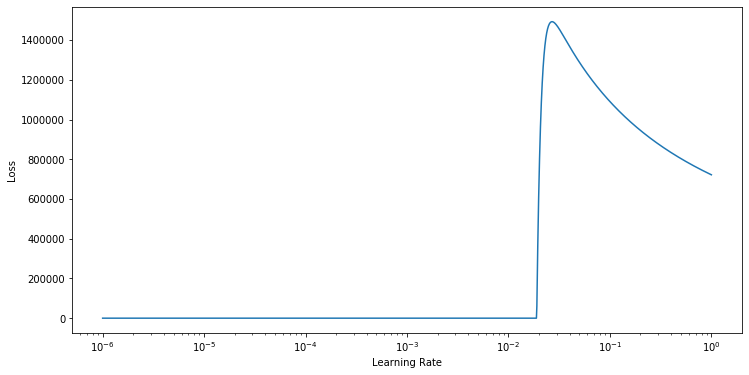

In [41]:
model.fit_generator(generator=training_generator, validation_data=validation_generator,
            callbacks=[lr_finder], epochs=2)

In [44]:
%matplotlib notebook

<IPython.core.display.Javascript object>


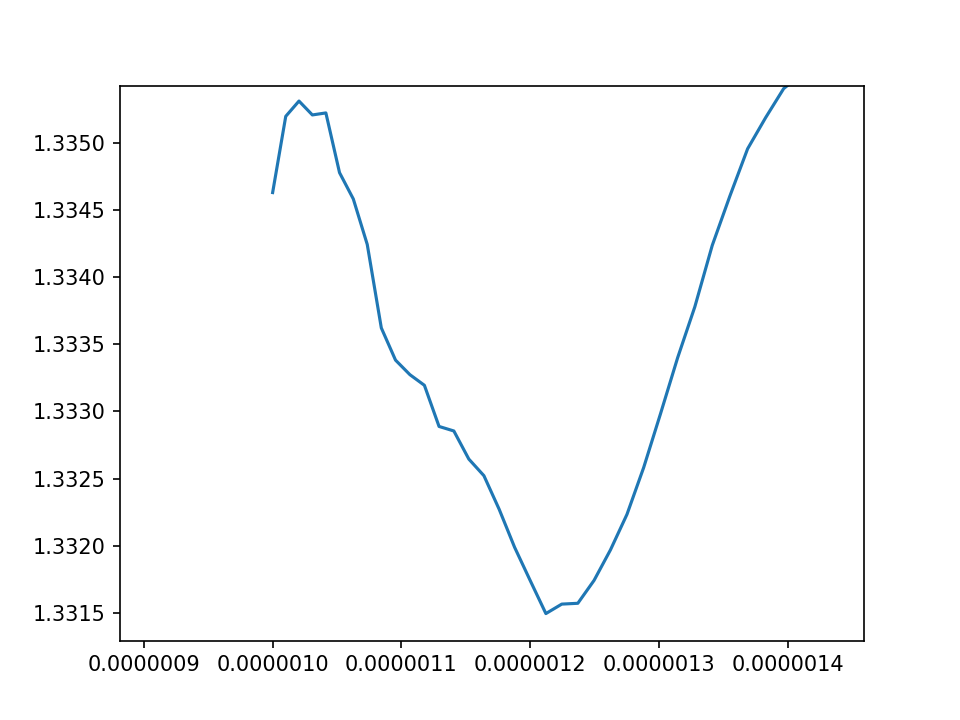

In [45]:
plt.plot(lr_finder.learning_rates[:len(lr_finder.losses)], lr_finder.losses)


In [15]:
training_generator[20]

(array([[[[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]],
 
         [[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]],
 
         [[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]],
 
         ...,
 
         [[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0.

In [51]:
all_x.shape

(38647800,)

In [5]:
model = load_model('data-generator-trin=76-truevalidation=53-true-validation-3')

OSError: SavedModel file does not exist at: data-generator-trin=76-truevalidation=53-true-validation-3/{saved_model.pbtxt|saved_model.pb}

In [58]:
model.save('data-generator-trin=76-truevalidation=53-true-validation-3')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: data-generator-trin=76-truevalidation=53-true-validation-3/assets


In [4]:

from keras.models import load_model


In [17]:
# load model
model = load_model('data-generator-trin=89-validation=52-true-validation22')
# summarize model.
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32, 32, 32, 1)]   0         
_________________________________________________________________
conv3d_12 (Conv3D)           (None, 31, 31, 31, 32)    288       
_________________________________________________________________
conv3d_13 (Conv3D)           (None, 30, 30, 30, 32)    8224      
_________________________________________________________________
conv3d_14 (Conv3D)           (None, 28, 28, 28, 32)    27680     
_________________________________________________________________
conv3d_15 (Conv3D)           (None, 26, 26, 26, 16)    13840     
_________________________________________________________________
max_pooling3d_7 (MaxPooling3 (None, 13, 13, 13, 16)    0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 35152)             0   

In [30]:
#   make dataset
predictions = model.predict(validation_generator)
p_y = np.argmax(predictions, axis=1)
y_gt = np.argmax(new_validation_all_y, axis=1)[:p_y.shape[0]]

In [52]:
predictions

array([[4.1479170e-01, 3.5469472e-01, 2.2843023e-01, 2.0833241e-03],
       [2.5768381e-01, 1.8080512e-01, 4.9489775e-01, 6.6613361e-02],
       [3.2349300e-02, 3.0930843e-02, 8.2971826e-02, 8.5374802e-01],
       ...,
       [5.1450427e-03, 3.6225595e-02, 2.2676855e-03, 9.5636171e-01],
       [5.5647999e-01, 5.5314790e-02, 3.1529558e-01, 7.2909631e-02],
       [9.9691403e-01, 2.5403199e-03, 1.0682918e-06, 5.4457044e-04]],
      dtype=float32)

In [50]:
p_y.shape

(13408,)

In [51]:
np.sum((p_y == y_gt)*1.0)

3352.0

In [46]:
p_y == y_gt

array([ True, False, False, ...,  True,  True,  True])

In [31]:
from sklearn.metrics import confusion_matrix

In [32]:
conf_m = confusion_matrix(y_gt, p_y)


In [33]:
conf_m

array([[ 857,  944,  936,  895],
       [ 758,  842,  819,  696],
       [ 872, 1045, 1016,  865],
       [ 690,  768,  768,  637]])

In [34]:
size_of_y_classes = np.sum((new_validation_all_y+1)/2, axis=0)


In [35]:
size_of_y_classes

array([3632., 3118., 3802., 2864.])

In [36]:
scaled_conf = conf_m*1.0

In [37]:
scaled_conf

array([[ 857.,  944.,  936.,  895.],
       [ 758.,  842.,  819.,  696.],
       [ 872., 1045., 1016.,  865.],
       [ 690.,  768.,  768.,  637.]])

In [38]:
for i in range(scaled_conf.shape[0]):
    scaled_conf[i,:] = scaled_conf[i,:] / size_of_y_classes[i]

In [39]:
scaled_conf

array([[0.23595815, 0.25991189, 0.25770925, 0.2464207 ],
       [0.24310455, 0.2700449 , 0.26266838, 0.22322001],
       [0.22935297, 0.27485534, 0.26722777, 0.22751184],
       [0.24092179, 0.26815642, 0.26815642, 0.2224162 ]])

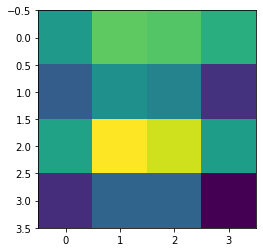

In [40]:
plt.imshow(conf_m)

In [73]:
np.sum([0.28193833, 0.2155837 , 0.28937225, 0.21310573])

1.00000001

In [29]:
from sklearn.metrics import f1_score
f1_score(y_gt, p_y , average='macro')

0.25336126196985986

In [16]:
all_x.shape

(124000, 15, 6, 3)

In [34]:
def count_number_of_ones(batch_data):
    return np.sum(np.reshape(convert_data_representation_to_point_cloud(batch_data),
                      [batch_data.shape[0],-1]), axis=1)

In [40]:
number_of_ones = ''
for i in range(32, all_x.shape[0],32):
    batch_data = all_x[i-32:i, :,:,:]
    ones = count_number_of_ones(batch_data)
    if number_of_ones == '':
        number_of_ones = ones
    else:
        number_of_ones = np.append(number_of_ones, ones)
        

/home/bahram/.conda/envs/tf1_15/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  """


(array([  177.,   454.,  1006.,  4111.,  3526.,  3772.,  3758.,  5781.,
         9498., 91885.]),
 array([16. , 23.4, 30.8, 38.2, 45.6, 53. , 60.4, 67.8, 75.2, 82.6, 90. ]),
 <a list of 10 Patch objects>)

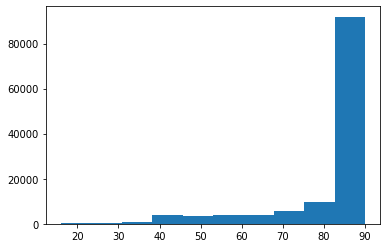

In [41]:
plt.hist(number_of_ones)

In [18]:
[i for i in range(0,161,16)]

[0, 16, 32, 48, 64, 80, 96, 112, 128, 144, 160]

In [27]:
np.sum(, axis=[1,2]).shape

TypeError: 'list' object cannot be interpreted as an integer

In [33]:
np.sum(np.reshape(convert_data_representation_to_point_cloud(all_x[:10,:,:,:]), [10,-1]), axis=1)

array([87., 85., 85., 90., 86., 86., 90., 89., 89., 73.])